# How HDBSCAN Works

HDBSCAN is a clustering algorithm developed by [Campello, Moulavi, and Sander](http://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14). It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. The goal of this notebook is to give you an overview of how the algorithm works and the motivations behind it. In contrast to the HDBSCAN paper I'm going to describe it without reference to DBSCAN. Instead I'm going to explain how I like to think about the algorithm, which aligns more closely with [Robust Single Linkage](http://cseweb.ucsd.edu/~dasgupta/papers/tree.pdf) with [flat cluster extraction](http://link.springer.com/article/10.1007%2Fs10618-013-0311-4) on top of it.

Before we get started we'll load up most of the libraries we'll need in the background, and set up our plotting (because I believe the best way to understand what is going on is to actually see it working in pictures).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 10, 'linewidths':0}

The next thing we'll need is some data. To make for an illustrative example we'll need the data size to be fairly small so we can see what is going on. It will also be useful to have several clusters, preferably of different kinds. Fortunately sklearn has facilities for generating sample clustering data so I'll make use of that and make a dataset of one hundred data points.

In [2]:
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
# plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)

In [3]:
def load_data(fpath: str, verbose: bool = False, last_col : bool = True) -> np.ndarray:
    """Load data from a csv file.

    Parameters
    ----------
    fpath : str
        Path to the csv file.

    Returns
    -------
    data : numpy.array
        Array containing the data from the csv file.
    """

    if verbose:
        print(f'Loading data from {fpath}...')

    with open(fpath) as f:
        lines = (line for line in f if not line.startswith('#'))
        DataIn = np.loadtxt(lines, delimiter=',', skiprows=1)

    if not last_col:
        DataIn = DataIn[:, :-1]
    
    # Normalize the data
    DataIn = np.divide(DataIn - np.min(DataIn, axis=0), np.max(DataIn, axis=0) - np.min(DataIn, axis=0))

    if verbose:
        print('Data Loading Completed...\n')

    return DataIn

Loading data from ../data/gaussian100b.csv...
Data Loading Completed...



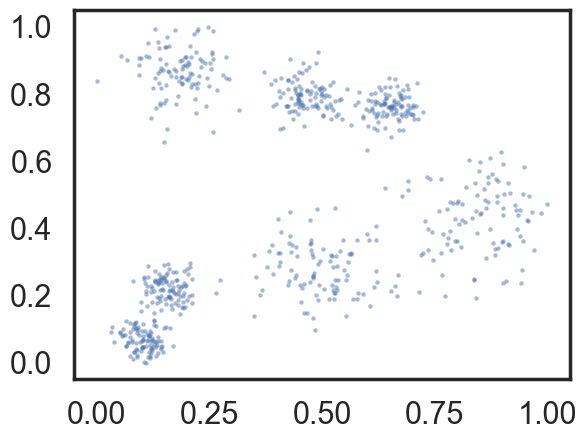

In [5]:
data = load_data(r'../data/gaussian100b.csv', verbose=True, last_col=True)
plt.scatter(data.T[0], data.T[1], color='b', **plot_kwds)

Now, the best way to explain HDBSCAN is actually just use it and then go through the steps that occurred along the way teasing out what is happening at each step. So let's load up the [hdbscan library](https://github.com/scikit-learn-contrib/hdbscan) and get to work.

In [6]:
import hdbscan

In [7]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=20, gen_min_span_tree=True)
clusterer.fit(data)

HDBSCAN(gen_min_span_tree=True, min_samples=20)

So now that we have clustered the data -- what actually happened? We can break it out into a series of steps

1. Transform the space according to the density/sparsity.
2. Build the minimum spanning tree of the distance weighted graph.
3. Construct a cluster hierarchy of connected components.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

## Transform the space

To find clusters we want to find the islands of higher density amid a sea of sparser noise -- and the assumption of noise is important: real data is messy and has outliers, corrupt data, and noise. The core of the clustering algorithm is single linkage clustering, and it can be quite sensitive to noise: a single noise data point in the wrong place can act as a bridge between islands, gluing them together. Obviously we want our algorithm to be robust against noise so we need to find a way to help 'lower the sea level' before running a single linkage algorithm.

How can we characterize 'sea' and 'land' without doing a clustering? As long as we can get an estimate of density we can consider lower density points as the 'sea'. The goal here is not to perfectly distinguish 'sea' from 'land' -- this is an initial step in clustering, not the ouput -- just to make our clustering core a little more robust to noise. So given an identification of 'sea' we want to lower the sea level. For practical purposes that means making 'sea' points more distant from each other and from the 'land'.

That's just the intuition however. How does it work in practice? We need a very inexpensive estimate of density, and the simplest is the distance to the *k*th nearest neighbor. If we have the distance matrix for our data (which we will need imminently anyway) we can simply read that off; alternatively if our metric is supported (and dimension is low) this is the sort of query that [kd-trees](http://scikit-learn.org/stable/modules/neighbors.html#k-d-tree) are good for. Let's formalise this and (following the DBSCAN, LOF, and HDBSCAN literature) call it the **core distance** defined for parameter *k* for a point *x* and denote as $\mathrm{core}_k(x)$. Now we need a way to spread apart points with low density (correspondingly high core distance). The simple way to do this is to define a new distance metric between points which we will call (again following the literature) the **mutual reachability distance**.  We define mutual reachability distance as follows:

<center>$d_{\mathrm{mreach-}k}(a,b) = \max \{\mathrm{core}_k(a), \mathrm{core}_k(b), d(a,b) \}$</center>

where $d(a,b)$ is the original metric distance between *a* and *b*. Under this metric dense points (with low core distance) remain the same distance from each other but sparser points are pushed away to be at least their core distance away from any other point. This effectively 'lowers the sea level' spreading sparse 'sea' points out, while leaving 'land' untouched. The caveat here is that obviously this is dependent upon the choice of *k*; larger *k* values interpret more points as being in the 'sea'. All of this is a little easier to understand with a picture, so let's use a *k* value of five. Then for a given point we can draw a circle for the core distance as the circle that touches the sixth nearest neighbor (counting the point itself), like so:

<img src="distance1.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

Pick another point and we can do the same thing, this time with a different set of neighbors (one of them even being the first point we picked out).

<img src="distance2.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

And we can do that a third time for good measure, with another set of six nearest neighbors and another circle with slightly different radius again.

<img src="distance3.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

Now if we want to know the mutual reachabiility distance between the blue and green points we can start by drawing in and arrow giving the distance between green and blue:

<img src="distance4.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

This passes through the blue circle, but not the green circle -- the core distance for green is larger than the distance between blue and green. Thus we need to mark the mutual reachability distance between blue and green as larger -- equal to the radius of the green circle (easiest to picture if we base one end at the green point).

<img src="distance4a.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

On the other hand the mutual reachablity distance from red to green is simply distance from red to green since that distance is greater than either core distance (i.e. the distance arrow passes through both circles).

<img src="distance5.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

In general there is [underlying theory](http://arxiv.org/pdf/1506.06422v2.pdf) to demonstrate that mutual reachability distance as a transform works well in allowing single linkage clustering to more closely approximate the hierarchy of level sets of whatever true density distribution our points were sampled from.

## Build the minimum spanning tree

Now that we have a new mutual reachability metric on the data we want start finding the islands on dense data. Of course dense areas are relative, and different islands may have different densities. Conceptually what we will do is the following: consider the data as a weighted graph with the data points as vertices and an edge between any two points with weight equal to the mutual reachability distance of those points.

Now consider a threshold value, starting high, and steadily being lowered. Drop any edges with weight above that threshold. As we drop edges we will start to disconnect the graph into connected components. Eventually we will have a hierarchy of connected components (from completely connected to completely disconnected) at varying threshold levels.

In practice this is very expensive: there are $n^2$ edges and we don't want to have to run a connected components algorithm that many times. The right thing to do is to find a minimal set of edges such that dropping any edge from the set causes a disconnection of components. But we need more, we need this set to be such that there is no lower weight edge that could connect the components. Fortunately graph theory furnishes us with just such a thing: the minimum spanning tree of the graph.

We can build the minimum spanning tree very efficiently via [Prim's algorithm](https://en.wikipedia.org/wiki/Prim%27s_algorithm) -- we build the tree one edge at a time, always adding the lowest weight edge that connects the current tree to a vertex not yet in the tree. You can see the tree HDBSCAN constructed below; note that this is the minimum spanning tree for *mutual reachability distance* which is different from the pure distance in the graph. In this case we had a *k* value of 5.

In the case that the data lives in a metric space we can use even faster methods, such as Dual Tree Boruvka to build the minimal spanning tree.

In [11]:
clusterer.minimum_spanning_tree_.to_pandas().head()

,from,to,distance
0,461,415,0.021175
1,467,461,0.021257
2,494,467,0.021364
3,453,415,0.021446
4,419,453,0.021807


c:\Users\hrush\.virtualenvs\Manim\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hrush\.virtualenvs\Manim\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: >

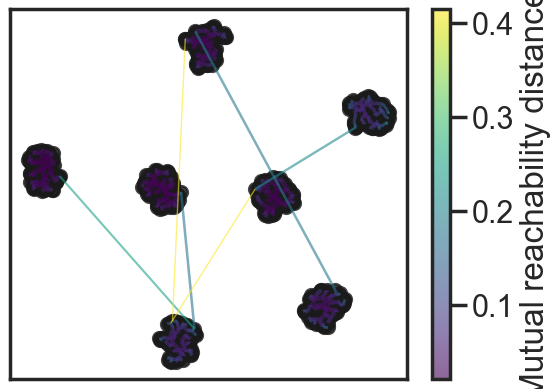

In [12]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=80, 
                                      edge_linewidth=1)

## Build the cluster hierarchy

Given the minimal spanning tree, the next step is to convert that into the hierarchy of connected components. This is most easily done in the reverse order: sort the edges of the tree by distance (in increasing order) and then iterate through, creating a new merged cluster for each edge. The only difficult part here is to identify the two clusters each edge will join together, but this is easy enough via a [union-find](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) data structure. We can view the result as a dendrogram as we see below:

<AxesSubplot:ylabel='distance'>

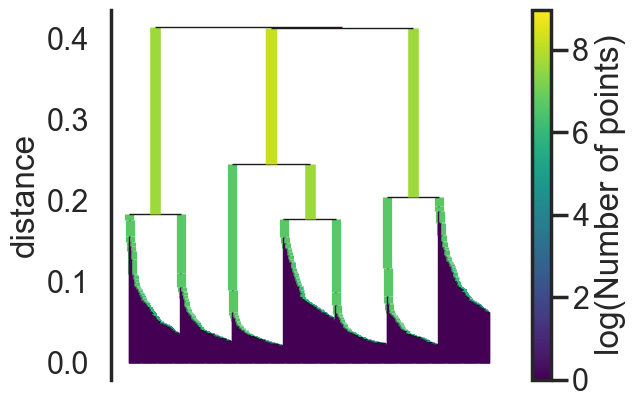

In [7]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

This brings us to the point where robust single linkage stops. We want more though; a cluster hierarchy is good, but we really want a set of flat clusters. We could do that by drawing a a horizontal line through the above diagram and selecting the clusters that it cuts through. This is in practice what [DBSCAN](http://scikit-learn.org/stable/modules/clustering.html#dbscan) effectively does (declaring any singleton clusters at the cut level as noise). The question is, how do we know where to draw that line? DBSCAN simply leaves that as a (very unintuitive) parameter. Worse, we really want to deal with variable density clusters and any choice of cut line is a choice of mutual reachability distance to cut at, and hence a single fixed density level. Ideally we want to be able to cut the tree at different places to select our clusters. This is where the next steps of HDBSCAN begin and create the difference from robust single linkage.

## Condense the cluster tree

The first step in cluster extraction is condensing down the large and complicated cluster hierarchy into a smaller tree with a little more data attached to each node. As you can see in the hierarchy above it is often the case that a cluster split is one or two points splitting off from a cluster; and that is the key point -- rather than seeing it as a cluster splitting into two new clusters we want to view it as a single persistent cluster that is 'losing points'. To make this concrete we need a notion of **minimum cluster size** which we take as a parameter to HDBSCAN. Once we have a value for minimum cluster size we can now walk through the hierarchy and at each split ask if one of the new clusters created by the split has fewer points than the minimum cluster size. If it is the case that we have fewer points than the minimum cluster size we declare it to be 'points falling out of a cluster' and have the larger cluster retain the cluster identity of the parent, marking down which points 'fell out of the cluster' and at what distance value that happened. If on the other hand the split is into two clusters each at least as large as the minimum cluster size then we consider that a true cluster split and let that split persist in the tree. After walking through the whole hierarchy and doing this we end up with a much smaller tree with a small number of nodes, each of which has data about how the size of the cluster at that node descreases over varying distance. We can visualize this as a dendrogram similar to the one above -- again we can have the width of the line represent the number of points in the cluster. This time, however, that width varies over the length of the line as points fall our of the cluster. For our data using a minimum cluster size of 5 the result looks like this:

<AxesSubplot:ylabel='$\\lambda$ value'>

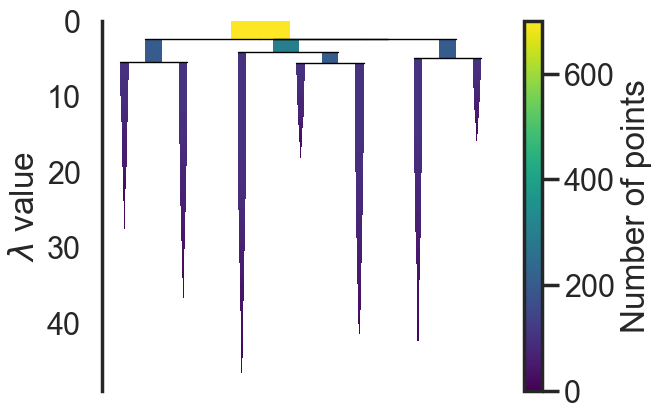

In [8]:
clusterer.condensed_tree_.plot()

This is much easier to look at and deal with, particularly in as simple a clustering problem as our current test dataset. However we still need to pick out clusters to use as a flat clustering. Looking at the plot above should give you some ideas about how one might go about doing this.

## Extract the clusters

Intuitively we want the choose clusters that persist and have a longer lifetime; short lived clusters are ultimately probably merely artifacts of the single linkage approach. Looking at the previous plot we could say that we want to choose those clusters that have the greatest area of ink in the plot. To make a flat clustering we will need to add a further requirement that, if you select a cluster, then you cannot select any cluster that is a descendant of it. And in fact that intuitive notion of what should be done is exactly what HDBSCAN does. Of course we need to formalise things to make it a concrete algorithm.

First we need a different measure than distance to consider the persistence of clusters; instead we will use $\lambda = \frac{1}{\mathrm{distance}}$. For a given cluster we can then define values $\lambda_{\mathrm{birth}}$ and $\lambda_{\mathrm{death}}$ to be the lambda value when the cluster split off and became its own cluster, and the lambda value (if any) when the cluster split into smaller clusters respectively. In turn, for a given cluster, for each point *p* in that cluster we can define the value $\lambda_p$ as the lambda value at which that point 'fell out of the cluster' which is a value somewhere between $\lambda_{\mathrm{birth}}$ and $\lambda_{\mathrm{death}}$ since the point either falls out of the cluster at some point in the cluster's lifetime, or leaves the cluster when the cluster splits into two smaller clusters. Now, for each cluster compute the **stability** to as

$\sum_{p \in \mathrm{cluster}} (\lambda_p - \lambda_{\mathrm{birth}})$.

Declare all leaf nodes to be selected clusters. Now work up through the tree (the reverse topological sort order). If the sum of the stabilities of the child clusters is greater than the stability of the cluster then we set the cluster stability to be the sum of the child stabilities. If, on the other hand, the cluster's stability is greater than the sum of its children then we declare the cluster to be a selected cluster, and unselect all its descendants. Once we reach the root node we call the current set of selected clusters our flat clsutering and return that.

Okay, that was wordy and complicated, but it really is simply performing our 'select the clusters in the plot with the largest total ink area' subject to descendant constraints that we explained earlier. We can select the clusters in the condensed tree dendrogram via this algorithm, and you get what you expect:

<AxesSubplot:ylabel='$\\lambda$ value'>

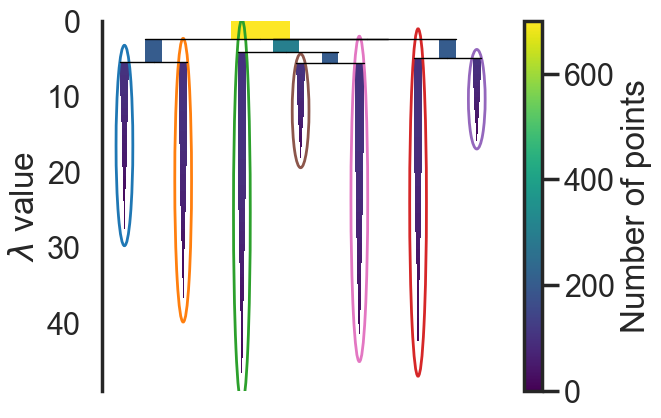

In [9]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Now that we have the clusters it is a simple enough matter to turn that into cluster labelling as per the sklearn API. Any point not in a selected cluster is simply a noise point (and assigned the label -1). We can do a little more though: for each cluster we have the $\lambda_p$ for each point *p* in that cluster; If we simply normalize those values (so they range from zero to one) then we have a measure of the strength of cluster membership for each point in the cluster. The hdbscan library returns this as a `probabilities_` attribute of the clusterer object. Thus, with labels and membership strengths in hand we can make the standard plot, choosing a color for points based on cluster label, and desaturating that color according the strength of membership (and make unclustered points pure gray).

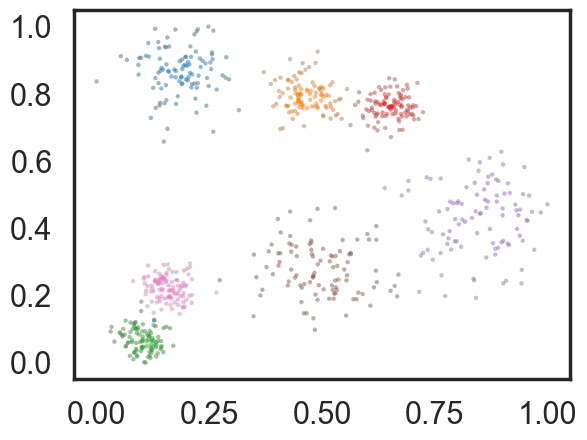

In [10]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(data.T[0], data.T[1], c=cluster_colors, **plot_kwds)

And that is how HDBSCAN works. It may seem somewhat complicated -- there are a fair number of moving parts to the algorithm -- but ultimately each part is actually very straightforward and can be optimized well. Hopefully with a better understanding both of the intuitions and some of the implementation details of HDBSCAN you will feel motivated to [try it out](https://github.com/scikit-learn-contrib/hdbscan). The library continues to develop, and will provide a base for new ideas including a near parameterless Persistent Density Clustering algorithm, and a new semi-supervised clustering algorithm.